# COMS W4705 - Homework 3
## Conditioned LSTM Language Model for Image Captioning
Daniel Bauer <bauer@cs.columbia.edu>

Follow the instructions in this notebook step-by step. Much of the code is provided (especially in part I, II, and III), but some sections are marked with **todo**. Make sure to complete all these sections.

Specifically, you will build the following components:

* Part I (14pts): Create encoded representations for the images in the flickr dataset using a pretrained image encoder(ResNet)
* Part II (14pts): Prepare the input caption data.
* Part III (24pts): Train an LSTM language model on the caption portion of the data and use it as a generator.
* Part IV (24pts): Modify the LSTM model to also pass a copy of the input image in each timestep.
* Part V (24pts): Implement beam search for the image caption generator.

As for homework 4, access to a GPU is required.

### Getting Started

There are a few required packages.

In [1]:
import os
import PIL # Python Image Library

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import ResNet18_Weights

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
    print("You won't be able to train the RNN decoder on a CPU, unfortunately.")
print(DEVICE)

cuda


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail:

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

If you are using Colab:
* The data is available on google drive. You can access the folder here:
https://drive.google.com/drive/folders/1sXWOLkmhpA1KFjVR0VjxGUtzAImIvU39?usp=sharing
* Sharing is only enabled for the lionmail domain. Please make sure you are logged into Google Drive using your Columbia UNI. I will not be able to respond to individual sharing requests from your personal account.

* Once you have opened the folder, click on "Shared With Me", then select the hw5data folder, and press shift+z. This will open the "add to drive" menu. Add the folder to your drive. (This will not create a copy, but just an additional entry point to the shared folder).

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the dataset beyond this course, I suggest that you submit your own download request here (it's free): https://forms.illinois.edu/sec/1713398



If you are running the code locally (or on a cloud VM): I also placed a copy in a Google cloud storage bucket here:
https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip

In [3]:
# OPTIONAL (if not using Colab and the data in Google Drive): Download the data.
!wget https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip

--2024-11-24 06:05:23--  https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115435617 (1.0G) [application/zip]
Saving to: ‘hw3data.zip’

hw3data.zip         100%[===================>]   1.04G   238MB/s    in 4.4s    

2024-11-24 06:05:28 (240 MB/s) - ‘hw3data.zip’ saved [1115435617/1115435617]



In [4]:
#Then unzip the data
!unzip hw3data.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: hw3data/Flickr8k_Dataset/2846785268_904c5fcf9f.jpg  
  inflating: hw3data/Flickr8k_Dataset/2846843520_b0e6211478.jpg  
  inflating: hw3data/Flickr8k_Dataset/2847514745_9a35493023.jpg  
  inflating: hw3data/Flickr8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: hw3data/Flickr8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: hw3data/Flickr8k_Dataset/2848266893_9693c66275.jpg  
  inflating: hw3data/Flickr8k_Dataset/2848571082_26454cb981.jpg  
  inflating: hw3data/Flickr8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: hw3data/Flickr8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: hw3data/Flickr8k_Dataset/2849194983_2968c72832.jpg  
  inflating: hw3data/Flickr8k_Dataset/2850719435_221f15e951.jpg  
  inflating: hw3data/Flickr8k_Dataset/2851198725_37b6027625.jpg  
  inflating: hw3data/Flickr8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: hw3data/Flickr8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: hw3data/Flickr8k_Dataset/28

The following variable should point to the location where the data is located.

In [5]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
MY_DATA_DIR="hw3data"

## Part I: Image Encodings (14 pts)

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists.

In [6]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f:
        return [line.strip() for line in image_list_f]

In [7]:
FLICKR_PATH="hw3data/"

In [8]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

Let's see how many images there are

In [9]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [10]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [11]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

We can use PIL to open and display the image:

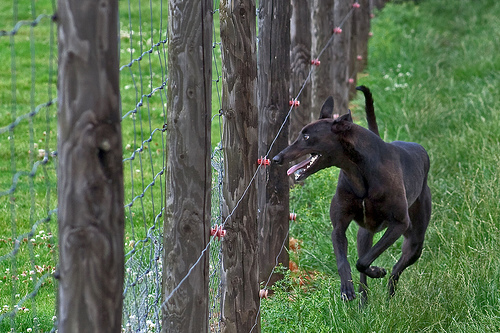

In [12]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

### Preprocessing

We are going to use an off-the-shelf pre-trained image encoder, the ResNet-18 network. Here is more detail about this model (not required for this project):

> Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778
> https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

The model was initially trained on an object recognition task over the ImageNet1k data. The task is to predict the correct class label for an image, from a set of 1000 possible classes.

To feed the flickr images to ResNet, we need to perform the same normalization that was applied to the training images. More details here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [13]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The resulting images, after preprocessing, are (3,224,244) tensors, where the first dimension represents the three color channels, R,G,B).

In [14]:
processed_image = preprocess(image)
processed_image.shape

torch.Size([3, 224, 224])

To the ResNet18 model, the images look like this:

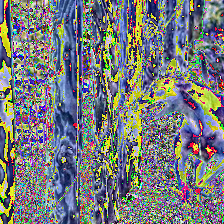

In [15]:
transforms.ToPILImage()(processed_image)

### Image Encoder
Let's instantiate the ReseNet18 encoder. We are going to use the pretrained weights available in torchvision.

In [16]:
img_encoder = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.7MB/s]


In [17]:
img_encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 512.

We will use the following hack: remove the last layer, then reinstantiate a Squential model from the remaining layers.

In [18]:
lastremoved = list(img_encoder.children())[:-1]
img_encoder = torch.nn.Sequential(*lastremoved).to(DEVICE) # also send it to GPU memory
img_encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Let's try the encoder.

In [19]:
def get_image(img_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, img_name))
    return preprocess(image)

In [20]:
preprocessed_image = get_image(train_list[0])
encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # unsqueeze required to add batch dim (3,224,224) becomes (1,3,224,224)
encoded.shape

torch.Size([1, 512, 1, 1])

The result isn't quite what we wanted: The final representation is actually a 1x1 "image" (the first dimension is the batch size).
We can just grab this one pixel:

In [21]:
encoded = encoded[:,:,0,0] #this is our final image encoded
encoded.shape

torch.Size([1, 512])

**TODO:** Because we are just using the pretrained encoder, we can simply encode all the images in a preliminary step. We will store them in one big tensor (one for each dataset, train, dev, test). This will save some time when training the conditioned LSTM because we won't have to recompute the image encodings with each training epoch. We can also save the tensors to disk so that we never have to touch the bulky image data again.

Complete the following function that should take a list of image names and return a tensor of size [n_images, 512] (where each row represents one image).

For example `encode_imates(train_list)` should return a [6000,512] tensor.

In [22]:
def encode_images(image_list):
    # pass #TODO....
    """
    Encodes a list of images using a pretrained encoder.
    """
    encoded_images = []

    with torch.no_grad():
      for img_name in image_list:
        preprocessed_image = get_image(img_name)
        encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # [1, 512, 1, 1]
        encoded = encoded[:,:,0,0] # [1, 512]
        encoded_images.append(encoded)

    return torch.cat(encoded_images, dim=0)

enc_images_train = encode_images(train_list)
enc_images_train.shape

torch.Size([6000, 512])

We can now save this to disk:

In [23]:
torch.save(enc_images_train, open('encoded_images_train.pt','wb'))

It's a good idea to save the resulting matrices, so we do not have to run the encoder again.

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the language model. We will train a text-only model first.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file.
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a \<START\> token on the left and an \<END\> token on the right.

For example, a single caption might look like this:
['\<START\>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '\<EOS\>'],

In [24]:
def read_image_descriptions(filename):
    image_descriptions = {}

    with open(filename,'r') as in_file:
        # pass # todo
        start = ['<START>']
        end = ['<EOS>']
        for line in in_file:

          img_name = line.split()[0][:-2]
          tokens = line.lower().split()[1:]

          captions = start + tokens + end

          if img_name not in image_descriptions:
            image_descriptions[img_name] = [captions]
          else:
            image_descriptions[img_name].append(captions)

    return image_descriptions

In [25]:
os.path.join(FLICKR_PATH, "Flickr8k.token.txt")

'hw3data/Flickr8k.token.txt'

In [26]:
descriptions = read_image_descriptions(os.path.join(FLICKR_PATH, "Flickr8k.token.txt"))

In [27]:
descriptions['1000268201_693b08cb0e.jpg']

[['<START>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'girl',
  'going',
  'into',
  'a',
  'wooden',
  'building',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'into',
  'a',
  'wooden',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'the',
  'stairs',
  'to',
  'her',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'in',
  'a',
  'pink',
  'dress',
  'going',
  'into',
  'a',
  'wooden',
  'cabin',
  '.',
  '<EOS>']]

The previous line shoudl return
<pre>[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<EOS>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<EOS>']]</pre>

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input
and output sequences using numeric representations.

**TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. This is similar to the word indices you created for homework 3 and 4.  

Make sure you create word indices for the three special tokens `<PAD>`, `<START>`, and `<EOS>` (end of sentence).

In [28]:
"""
Next, we need to create a lookup table from the training data mapping words to integer indices,
so we can encode input and output sequences using numeric representations.
Create a set of tokens in the training data first, then convert the set into a list and sort it.
"""

special_tokens = ['<PAD>', '<START>', '<EOS>']
token_set = set()

for captions in descriptions.values():
  for caption in captions:
    # print(caption)
    token_set.update(caption)

token_set -= set(special_tokens)
sorted_tokens = sorted(token_set)
final_tokens = special_tokens + sorted_tokens
# final_tokens

In [29]:
id_to_word = {id: token for id, token in enumerate(final_tokens)} #todo
# id_to_word[0] = "<PAD>"
# id_to_word[1] = "<START>"
# id_to_word[2] = "<EOS>"
word_to_id = {token: id for id, token in id_to_word.items()} # todo

In [30]:
word_to_id['cat'] # should print an integer

1349

In [31]:
id_to_word[1] # should print a token

'<START>'

In [32]:
len(id_to_word) == len(word_to_id)  # Should be equal

True

In [33]:
print(id_to_word)

{0: '<PAD>', 1: '<START>', 2: '<EOS>', 3: '!', 4: '"', 5: '#', 6: '&', 7: "'", 8: "'n'", 9: "'s", 10: "'s-eye-view", 11: "'slide", 12: '(', 13: ')', 14: ',', 15: '-', 16: '-ependent', 17: '.', 18: '08', 19: '1', 20: '10', 21: '104', 22: '11', 23: '12', 24: '13', 25: '13406', 26: '157', 27: '17', 28: '19', 29: '1915', 30: '1923', 31: '1950s', 32: '2', 33: '2008', 34: '21', 35: '22', 36: '23', 37: '25', 38: '28', 39: '281', 40: '29', 41: '3', 42: '3-wheeler', 43: '30', 44: '32', 45: '33', 46: '3rd', 47: '4', 48: '4-wheel', 49: '4-wheeler', 50: '42', 51: '4x4', 52: '5', 53: '50', 54: '52', 55: '528', 56: '57', 57: '58', 58: '6', 59: '625', 60: '661', 61: '7', 62: '75', 63: '8', 64: '80', 65: '84', 66: '90', 67: '93', 68: '97', 69: ':', 70: ';', 71: '?', 72: 'a', 73: 'a-frame', 74: 'abandon', 75: 'abandoned', 76: 'abarrotes', 77: 'abdomen', 78: 'ability', 79: 'aboard', 80: 'aboriginal', 81: 'about', 82: 'above', 83: 'above-ground', 84: 'abs', 85: 'abseiling', 86: 'ac', 87: 'accelerates', 8

In [34]:
id_to_word[word_to_id['cat']] == 'cat'

True

Note that we do not need an UNK word token because we will only use the model as a generator, once trained.

## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input.

We will use the LSTM implementation provided by PyTorch. The core idea here is that the recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different position, but the weights for these positions are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [35]:
MAX_LEN = max(len(description) for image_id in train_list for description in descriptions[image_id])
MAX_LEN

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word.
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence

`['<START>', 'a', 'black', 'dog', '<EOS>']`

We would train the model using the following input/output pairs (note both sequences are padded to the right up to MAX_LEN)

| i | input                                 | output                              |
|---|---------------------------------------|-------------------------------------|
| 0 |[`<START>`,`<PAD>`,`<PAD>`,`<PAD>`,...]| [`a`,`<PAD>`,`<PAD>`,`<PAD>`,...    |  
| 1 |[`<START>`,`a`,`<PAD>`,`<PAD>`,...]    | [`a`,`black`,`<PAD>`,`<PAD>`,...    |
| 2 |[`<START>`,`a`,`black`,`<PAD>`,...]    | [`a`,`black`,`dog`,`<PAD>`,...      |
| 3 |[`<START>`,`a`,`back`,`dog`,...]       | [`a`,`black`,`dog`,`<EOS>`,...      |

Here is the lange model in pytorch. We will choose input embeddings of dimensionality 512 (for simplicitly, we are not initializing these with pre-trained embeddings here). We will also use 512 for the hidden state vector and the output.

In [36]:
from torch import nn

vocab_size = len(word_to_id)+1
class GeneratorModel(nn.Module):

    def __init__(self):
        super(GeneratorModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(512, 512, num_layers = 1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512,vocab_size)

    def forward(self, input_seq):
        hidden = self.lstm(self.embedding(input_seq))
        out = self.output(hidden[0])
        return out

The input sequence is an integer tensor of size `[batch_size, MAX_LEN]`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with '<PAD>'.

For each input example, the model returns a distribution over possible output words. The model output is a tensor of size `[batch_size, MAX_LEN, vocab_size]`. vocab_size is the number of vocabulary words, i.e. len(word_to_id)

### Creating a Dataset for the text training data

**TODO**: Write a Dataset class for the text training data. The __getitem__ method should return an (input_encoding, output_encoding) pair for a single item. Both input_encoding and output_encoding should be tensors of size `[MAX_LEN]`, encoding the padded input/output sequence as illustrated above.

I recommend to first read in all captions in the __init__ method and store them in a list. Above, we used the get_image_descriptions function to load the image descriptions into a dictionary. Iterate through the images in img_list, then access the corresponding captions in the `descriptions` dictionary.

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc.


In [37]:
MAX_LEN = 40

class CaptionDataset(Dataset):

    def __init__(self, img_list):

        self.data = []

        # pass # TODO complete this method
        for img_name in img_list:
          if img_name in descriptions:
            for caption in descriptions[img_name]:
              caption_ids = [word_to_id[word] for word in caption]
              input_encoding = caption_ids[:-1]
              output_encoding = caption_ids[1:]

              input_encoding = input_encoding + [word_to_id['<PAD>']] *(MAX_LEN - len(input_encoding))
              output_encoding = output_encoding + [word_to_id['<PAD>']] * (MAX_LEN - len(output_encoding))

              self.data.append((torch.tensor(input_encoding, dtype=torch.long),
                                torch.tensor(output_encoding, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self,k):

        input_enc, output_enc = self.data[k]

        return input_enc, output_enc

Let's instantiate the caption dataset and get the first item. You want to see something like this:

for the input:
<pre>
tensor([   1,   74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922,
        7125,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>
for the output:
<pre>
    tensor([  74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922, 7125,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>

In [38]:
data = CaptionDataset(train_list)

In [39]:
i, o = data[0]
i

tensor([   1,   72,  803, 2310, 4013, 6486,  168,   72, 8684, 2310, 3920, 7920,
        7123,   17,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [40]:
o

tensor([  72,  803, 2310, 4013, 6486,  168,   72, 8684, 2310, 3920, 7920, 7123,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [41]:
# check
print(len(i), len(o))
print(i[-1], o[-1])

40 40
tensor(0) tensor(0)


Let's try the model:

In [42]:
model = GeneratorModel().to(DEVICE)

In [43]:
model(i.to(DEVICE)).shape   # should return a [40, vocab_size]  tensor.

torch.Size([40, 8922])

### Training the Model

The training function is identical to what you saw in homework 3 and 4.

In [44]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        inputs,targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        # Run the forward pass of the model
        logits = model(inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

Run the training until the accuracy reaches about 0.5 (this would be high for a language model on open-domain text, but the image caption dataset is comparatively small and closed-domain). This will take about 5 epochs.

In [45]:
train()

Current average loss: 9.085350036621094
Current average loss: 4.91160786033857
Current average loss: 4.439383251750054
Current average loss: 4.210116894934265
Current average loss: 4.075855856821721
Current average loss: 3.9665273568349444
Current average loss: 3.874427240422482
Current average loss: 3.8069992187870043
Current average loss: 3.753179745132408
Current average loss: 3.7054357314347954
Current average loss: 3.6643545841956353
Current average loss: 3.6260671736867076
Current average loss: 3.593084358355088
Current average loss: 3.5611290858398483
Current average loss: 3.5318219661712646
Current average loss: 3.5065936762678236
Current average loss: 3.483826684177406
Current average loss: 3.4605947684568914
Current average loss: 3.4428725895254164
Training loss epoch: 3.429825483194987
Average accuracy epoch: 0.38


### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>", "<PAD>","<PAD>"...]`, use the model to predict the most likely word in the next position. Append the word to the input sequence and then continue until `"<EOS>"` is predicted or the sequence reaches `MAX_LEN` words.

In [46]:
import numpy as np

def decoder():
    # pass # TODO COMPLETE THIS METHHOD
    model.eval()

    id_sentence = [word_to_id["<START>"]]
    id_sentence.extend([word_to_id["<PAD>"]] *(MAX_LEN-1))

    caption = ['<START>']

    for i in range(1, MAX_LEN):

      input_tensor = torch.tensor([id_sentence], dtype=torch.long).to(DEVICE)
      with torch.no_grad():
        logits = model(input_tensor)

      current_logits = logits[0, i-1]
      next_word_id = torch.argmax(current_logits).item()
      pred = id_to_word[next_word_id]
      caption.append(pred)
      id_sentence[i] = next_word_id

      if pred == "<EOS>":
        break

    return caption

In [47]:
decoder()

['<START>',
 'a',
 'man',
 'in',
 'a',
 'blue',
 'shirt',
 'and',
 'a',
 'black',
 'and',
 'white',
 'dog',
 'is',
 'running',
 'on',
 'a',
 'beach',
 '.',
 '<EOS>']

this will return something like
['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'dress',
 'walks',
 'by',
 'a',
 'small',
 'white',
 'building',
 '.',
 '<EOS>']

This simple decoder will of course always predict the same sequence (and it's not necessarily a good one).

**TODO:** Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Make sure to apply torch.softmax() to convert the output activations into a distribution.

To sample fromt he distribution, I recommend you take a look at [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), which takes the distribution as a parameter p.

In [48]:
import numpy as np

def sample_decoder():
    # pass # TODO COMPLETE THIS METHOD

    model.eval()

    id_sentence = [word_to_id["<START>"]]
    id_sentence.extend([word_to_id["<PAD>"]] *(MAX_LEN-1))

    caption = ['<START>']

    for i in range(1, MAX_LEN):

      input_tensor = torch.tensor([id_sentence], dtype=torch.long).to(DEVICE)
      with torch.no_grad():
        logits = model(input_tensor)

      current_logits = logits[0, i-1]
      probabilities = torch.softmax(current_logits, dim=-1).cpu().numpy()
      next_word_id = np.random.choice(len(probabilities), p=probabilities)

      pred = id_to_word[next_word_id]
      caption.append(pred)
      id_sentence[i] = next_word_id


      if pred == "<EOS>":
        break

    return caption


for i in range(5):
    print(sample_decoder())

['<START>', 'baby', 'walking', 'past', 'logo', 'near', 'an', 'ot', '.', '<EOS>']
['<START>', 'a', 'person', 'doing', 'riding', 'a', 'horse', 'near', 'three', 'photo', '.', '<EOS>']
['<START>', 'a', 'man', 'with', 'a', 'white', 'cowboy', 'hat', 'holding', 'a', 'crosswalk', '.', '<EOS>']
['<START>', 'a', 'man', 'wearing', 'a', 'few', 'makeup', 'walks', 'down', 'the', 'medatative', 'of', 'rocks', 'into', 'a', 'lake', '.', '<EOS>']
['<START>', 'a', 'young', 'boy', 'has', 'just', 'been', 'a', 'tree', 'on', 'the', 'shoreline', 'of', 'a', 'beach', '.', '<EOS>']


Some example outputs (it's stochastic, so your results will vary

<pre>
['<START>', 'people', 'on', 'rocky', 'ground', 'swinging', 'basketball', '<EOS>']
['<START>', 'the', 'two', 'hikers', 'take', 'a', 'tandem', 'leap', 'while', 'another', 'is', 'involving', 'watching', '.', '<EOS>']
['<START>', 'a', 'man', 'attached', 'to', 'a', 'bicycle', 'rides', 'a', 'motorcycle', '.', '<EOS>']
['<START>', 'a', 'surfer', 'is', 'riding', 'a', 'wave', 'in', 'the', 'ocean', '.', '<EOS>']
['<START>', 'a', 'child', 'plays', 'in', 'a', 'round', 'fountain', '.', '<EOS>']
</pre>

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input.

## Part III - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image.

We will concatenate the 512-dimensional image representation to each 512-dimensional token embedding. The LSTM will therefore see input representations of size 1024.

**TODO**: Write a new Dataset class for the combined image captioning data set. Each call to __getitem__ should return a triple  (image_encoding, input_encoding, output_encoding) for a single item. Both input_encoding and output_encoding should be tensors of size [MAX_LEN], encoding the padded input/output sequence as illustrated above. The image_encoding is the size [512] tensor we pre-computed in part I.

Note: One tricky issue here is that each image corresponds to 5 captions, so you have to find the correct image for each caption. You can create a mapping from image names to row indices in the image encoding tensor. This way you will be able to find each image by it's name.

In [49]:
MAX_LEN = 40

class CaptionAndImage(Dataset):

    def __init__(self, img_list):

        self.img_data = torch.load(open("encoded_images_train.pt",'rb')) # suggested
        self.img_name_to_id = dict([(i,j) for (j,i) in enumerate(img_list)])

        self.data = []
        # TODO COMPLETE THIS METHOD
        for img_name in img_list:
          if img_name in descriptions:
            img_idx = self.img_name_to_id[img_name]
            image_encoding = self.img_data[img_idx]
            for caption in descriptions[img_name]:
              caption_ids = [word_to_id[word] for word in caption]
              input_encoding = caption_ids[:-1]
              output_encoding = caption_ids[1:]

              input_encoding = input_encoding + [word_to_id['<PAD>']] *(MAX_LEN - len(input_encoding))
              output_encoding = output_encoding + [word_to_id['<PAD>']] * (MAX_LEN - len(output_encoding))


              self.data.append((
                  torch.tensor(image_encoding, dtype=torch.float32),
                  torch.tensor(input_encoding, dtype=torch.long),
                  torch.tensor(output_encoding, dtype=torch.long)
                  ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self,k):

        img_data, input_enc, output_enc = self.data[k]

        return img_data, input_enc, output_enc

In [50]:
joint_data = CaptionAndImage(train_list)
img, i, o = joint_data[0]
img.shape # should return torch.Size([512])

<ipython-input-49-a86398cf1643>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.img_data = torch.load(open("encoded_images_train.pt",'rb')) # suggested
<ipython-input-

torch.Size([512])

In [51]:
i.shape # should return torch.Size([40])

torch.Size([40])

In [52]:
o.shape # should return torch.Size([40])

torch.Size([40])

**TODO: Updating the model**
Update the language model code above to include a copy of the image for each position.
The forward function of the new model should take two inputs:
    
   1. a `(batch_size, 2048)` ndarray of image encodings.
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences.
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

The LSTM will take input dimension 1024 instead of 512 (because we are concatenating the 512-dim image encoding).

In the forward function, take the image and the embedded input sequence (i.e. AFTER the embedding was applied), and concatenate the image to each input. This requires some tensor manipulation. I recommend taking a look at [torch.Tensor.expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) and [torch.Tensor.cat](https://pytorch.org/docs/stable/generated/torch.Tensor.cat.html).



In [53]:
vocab_size = len(word_to_id)+1

class CaptionGeneratorModel(nn.Module):

    def __init__(self):
        super(CaptionGeneratorModel, self).__init__()
        # TODO COMPLETE THIS METHOD
        self.embedding = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(1024, 512, num_layers=1, batch_first = True)
        self.output = nn.Linear(512, vocab_size)

    def forward(self, img, input_seq):

        # TODO COMPLETE THIS METHOD
        # out = None # replace

        embedded_seq = self.embedding(input_seq) # [batch_size, MAX_LEN, 512]
        # print("embedded_seq", embedded_seq.shape)
        img_expanded = img.unsqueeze(1).expand(-1, embedded_seq.size(1), -1)
        # print("img_expanded", img_expanded.shape)
        lstm_input = torch.cat((embedded_seq, img_expanded), dim=2) # [batch_size, MAX_LEN, 1025]

        lstm_out, _ = self.lstm(lstm_input)
        out = self.output(lstm_out)

        return out

Let's try this new model on one item:

In [54]:
model = CaptionGeneratorModel().to(DEVICE)

In [55]:
item = joint_data[0]
img, input_seq, output_seq = item

In [56]:
logits = model(img.unsqueeze(0).to(DEVICE), input_seq.unsqueeze(0).to(DEVICE))

logits.shape # should return (1,40,8922) = (batch_size, MAX_LEN, vocab_size)

torch.Size([1, 40, 8922])

The training function is, again, mostly unchanged. Keep training until the accuracy exceeds 0.5.

In [57]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(joint_data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):
        img, inputs, targets = batch

        img = img.to(DEVICE)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        # Run the forward pass of the model
        logits = model(img, inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

In [58]:
train()

Current average loss: 9.057699203491211
Current average loss: 4.952351220763556
Current average loss: 4.535964902953722
Current average loss: 4.286801167104727
Current average loss: 4.115058907844182
Current average loss: 3.988108383681246
Current average loss: 3.8967062209092838
Current average loss: 3.8192575858765085
Current average loss: 3.7554874253481367
Current average loss: 3.7005660803812854
Current average loss: 3.6508913557012597
Current average loss: 3.6083958783439893
Current average loss: 3.57344688245597
Current average loss: 3.537320553202706
Current average loss: 3.5033543218807353
Current average loss: 3.4745244034761433
Current average loss: 3.4516994722331784
Current average loss: 3.424109501392963
Current average loss: 3.400850118762053
Training loss epoch: 3.3832093424479166
Average accuracy epoch: 0.38


**TODO: Testing the model**:
Rewrite the greedy decoder from above to take an encoded image representation as input.

In [59]:
def greedy_decoder(img):
    #TODO: Complete this method
    model.eval()

    id_sentence = [word_to_id["<START>"]]
    id_sentence.extend([word_to_id["<PAD>"]] *(MAX_LEN-1))

    img_tensor = img.unsqueeze(0) if img.dim() == 1 else img
    img_tensor = img_tensor.to(DEVICE)

    result = ['<START>']

    for i in range(1, MAX_LEN):

      input_tensor = torch.tensor([id_sentence], dtype=torch.long).to(DEVICE)

      with torch.no_grad():
        logits = model(img_tensor, input_tensor)

      current_logits = logits[0, i-1]
      next_word_id = torch.argmax(current_logits).item()
      pred = id_to_word[next_word_id]

      result.append(pred)
      id_sentence[i] = next_word_id

      if pred == "<EOS>":
        break

    return result

Now we can load one of the dev images, pass it through the preprocessor and the image encoder, and then into the decoder!

['<START>', 'a', 'young', 'girl', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'rock', '.', '<EOS>']


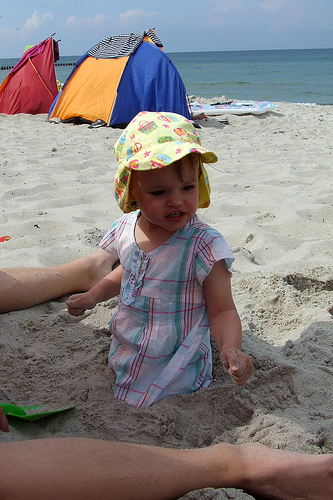

In [60]:
raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[199]))
preprocessed_img = preprocess(raw_img).to(DEVICE)
encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))
caption = greedy_decoder(encoded_img)
print(caption)
raw_img

The result should look pretty good for most images, but the model is prone to hallucinations.

## Part IV - Beam Search Decoder (24 pts)

**TODO** Modify the simple greedy decoder for the caption generator to use beam search.
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences.

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates.

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated.

Note that you cannot use the occurence of the `"<EOS>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam.

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n.

In [66]:
def img_beam_decoder(n, img):

    # TODO: Complete this method
    model.eval()

    img_tensor = img.unsqueeze(0) if img.dim() == 1 else img
    img_tensor = img_tensor.to(DEVICE)

    start_token = [word_to_id["<START>"]]
    beam = [(1.0, start_token)] #(probability, sequence)

    for _ in range(1, MAX_LEN):
      new_beam = []

      for prob, seq in beam:

        input_tensor = torch.tensor([seq + [word_to_id["<PAD>"]] * (MAX_LEN-len(seq))], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
          logits = model(img_tensor, input_tensor)

        current_logits = logits[0, len(seq)-1]
        probs = torch.softmax(current_logits, dim=-1)

        for word_id, word_prob in enumerate(probs):
          new_prob = prob * word_prob.item()
          new_seq = seq + [word_id]
          new_beam.append((new_prob, new_seq))

      new_beam = sorted(new_beam, key=lambda x:x[0], reverse = True)[:n]
      beam = new_beam


    best_seq = max(beam, key=lambda x:x[0])[1]

    if word_to_id["<EOS>"] in best_seq:
        best_seq = best_seq[:best_seq.index(word_to_id["<EOS>"]) + 1]

    result = [id_to_word[word_id] for word_id in best_seq]

    return result

**TODO** Finally, before you submit this assignment, please show 3 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5.

In [68]:
#todo
import matplotlib.pyplot as plt

def visualize_caption(dev_list):

  for idx, img_name in enumerate(dev_list[:10]):
    raw_img = PIL.Image.open(os.path.join(IMG_PATH, img_name))
    preprocessed_img = preprocess(raw_img).to(DEVICE)
    encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))

    greedy_caption = greedy_decoder(encoded_img)
    beam3_caption = img_beam_decoder(3, encoded_img)
    beam5_caption = img_beam_decoder(5, encoded_img)

    plt.imshow(raw_img)
    plt.axis('off')
    plt.title(f"Image {idx} Captioning Results")
    # plt.figtext(0.5, 0.15, f"Greedy: {' '.join(greedy_caption)}", wrap=True, horizontalalignment='center', fontsize=10)
    # plt.figtext(0.5, 0.1, f"Beam Search (n=3): {' '.join(beam3_caption)}", wrap=True, horizontalalignment='center', fontsize=10)
    # plt.figtext(0.5, 0.05, f"Beam Search (n=5): {' '.join(beam5_caption)}", wrap=True, horizontalalignment='center', fontsize=10)
    plt.show()

    print(f"Image {idx}: {img_name}")
    print("Greedy Decoder:", " ".join(greedy_caption))
    print("Beam Search (n=3):", " ".join(beam3_caption))
    print("Beam Search (n=5):", " ".join(beam5_caption))

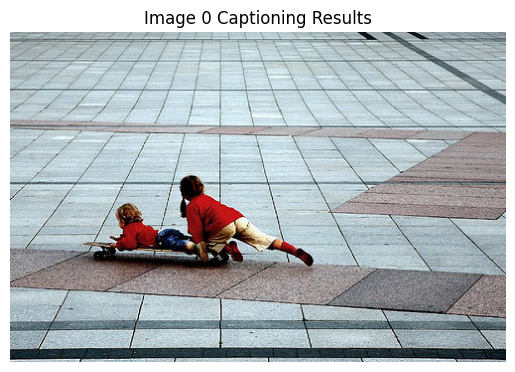

Image 0: 2090545563_a4e66ec76b.jpg
Greedy Decoder: <START> a man is sitting on a skateboard . <EOS>
Beam Search (n=3): <START> a young boy wearing a white shirt is standing on a skateboard . <EOS>
Beam Search (n=5): <START> a man is sitting on a skateboard . <EOS>


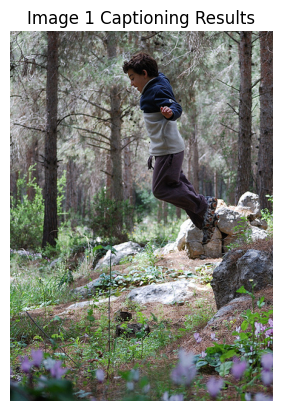

Image 1: 3393035454_2d2370ffd4.jpg
Greedy Decoder: <START> a man is standing on a rock face . <EOS>
Beam Search (n=3): <START> a man is standing on a rock face . <EOS>
Beam Search (n=5): <START> a man is standing on a rock face . <EOS>


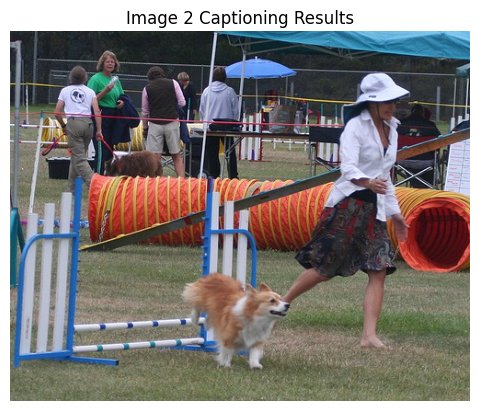

Image 2: 3695064885_a6922f06b2.jpg
Greedy Decoder: <START> a dog is jumping over a white dog . <EOS>
Beam Search (n=3): <START> a group of people are playing with a white dog . <EOS>
Beam Search (n=5): <START> a group of people are sitting on a bench . <EOS>


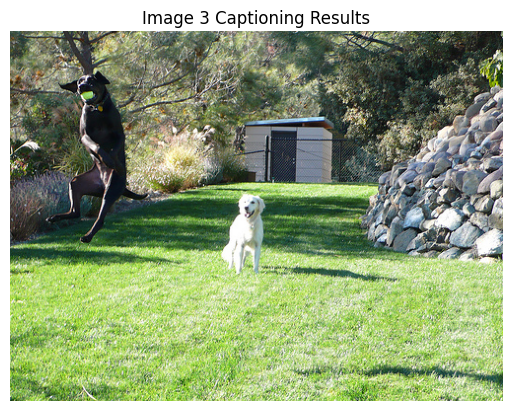

Image 3: 1679557684_50a206e4a9.jpg
Greedy Decoder: <START> a black dog is running through a field . <EOS>
Beam Search (n=3): <START> a black dog is running through the grass . <EOS>
Beam Search (n=5): <START> a black dog runs through the grass . <EOS>


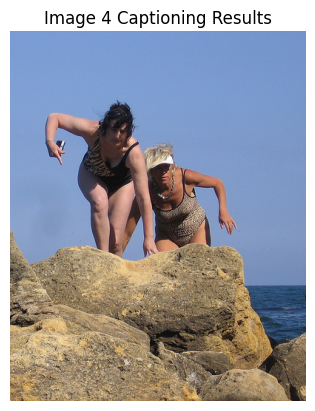

Image 4: 3582685410_05315a15b8.jpg
Greedy Decoder: <START> a man is standing on a rock climbing . <EOS>
Beam Search (n=3): <START> a man is standing on a rock climbing . <EOS>
Beam Search (n=5): <START> a man is standing on a rock climbing . <EOS>


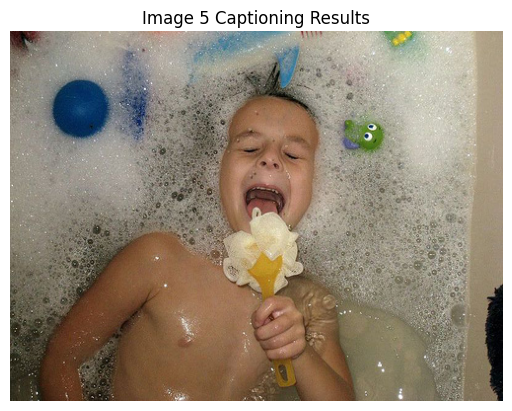

Image 5: 1579798212_d30844b4c5.jpg
Greedy Decoder: <START> a baby with a baby in a blue shirt is holding a baby in a blue and blue toy . <EOS>
Beam Search (n=3): <START> a young boy in a blue shirt is playing in a pool . <EOS>
Beam Search (n=5): <START> a young boy in a blue shirt is playing in a pool . <EOS>


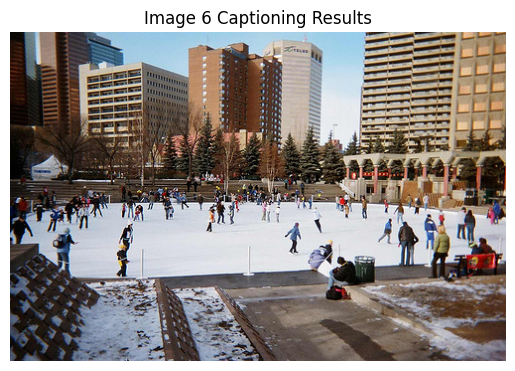

Image 6: 269650644_059a84ece5.jpg
Greedy Decoder: <START> a group of people are standing on a snowy hill . <EOS>
Beam Search (n=3): <START> a group of people are standing on a snowy hill . <EOS>
Beam Search (n=5): <START> a group of people are standing on a snowy hill . <EOS>


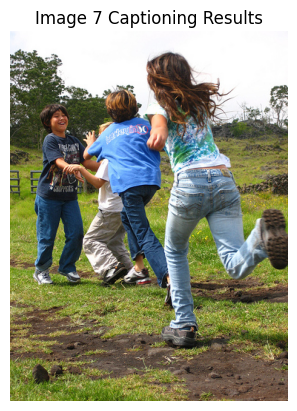

Image 7: 2596619849_7b635dd310.jpg
Greedy Decoder: <START> a young boy in a white shirt is jumping over a tree . <EOS>
Beam Search (n=3): <START> a young boy in a blue shirt is running through the grass . <EOS>
Beam Search (n=5): <START> a young boy wearing a blue shirt is walking through a field . <EOS>


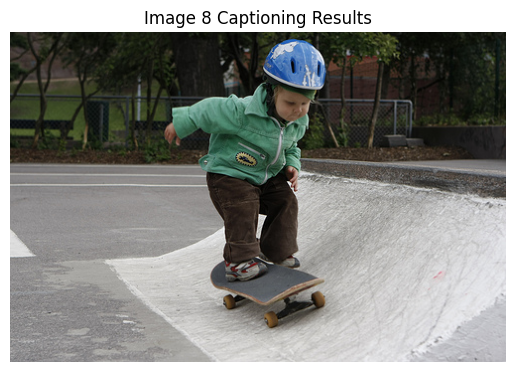

Image 8: 2635164923_2a774f7854.jpg
Greedy Decoder: <START> a boy in a red shirt is walking on a skateboard . <EOS>
Beam Search (n=3): <START> a young boy wearing a blue shirt is standing on a skateboard . <EOS>
Beam Search (n=5): <START> a young boy wearing a blue shirt is standing on a skateboard . <EOS>


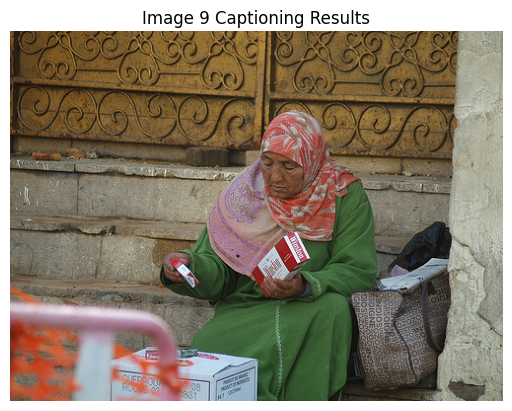

Image 9: 3583321426_f373c52161.jpg
Greedy Decoder: <START> a man wearing a red jacket is sitting on a red bench . <EOS>
Beam Search (n=3): <START> a man wearing a blue shirt is sitting on a bench . <EOS>
Beam Search (n=5): <START> a man wearing a blue shirt is sitting on a bench . <EOS>


In [69]:
visualize_caption(dev_list)